# i-Scream 데이터 분석

## data types
- DKT에서 하나의 행 == interaction

userID
- 사용자 별 고유번호
- 총 6698명의 unique

assessmentitemID
- 사용자가 푼 문항의 일련 번호
- 9,454개의 unique
- 규칙
    - 첫 자리는 A
    - 그 다음 6자리 시험지 번호
    - 마지막 3자리는 시험지 내 문항의 번호

testID
- 시험지의 일련 번호
- 1537개의 unique
- 규칙
    - 첫 자리는 A
    - 첫 자리 3개 + 마지막 3개 는 시험지 번호
    - 가운데는 날려도 괜찮음.
    - 앞의 3자리에서 가운데만 1~9

answerCode
- 정답/오답 여부
- 정답이 약 65%

Timestamp
- 사용자가 interaction을 시작한 시간

KnowleadgeTag
- 문항의 중분류
- 912개의 unique

# 다음과 같은 작업을 수행합니다

1.lgbm
- feature engeineering
- hyperparameter tuning
    - auto sklearn(https://dacon.io/en/codeshare/5160)
    


In [ ]:
!pip install seaborn
!pip install matplotlib

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import warnings
warnings.filterwarnings('ignore')
# from Feature_Engineering.sehoon import *
# from Feature_Engineering.seungjun import *



In [4]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'pandas version':15s} <> {pd.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
pandas version  <> 2.1.4


In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

# 경로 수정해주세요!
data_dir = '/data/ephemeral/data/'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
# df= pd.read_csv(data_dir + 'train_data.csv', dtype=dtype, parse_dates=['Timestamp'])

df_train = pd.read_csv(data_dir + 'train_data.csv', parse_dates=["Timestamp"])
df_test = pd.read_csv(data_dir + 'test_data.csv', parse_dates=["Timestamp"])

df_train['dataset'] = 1
df_test['dataset'] = 2

df = pd.concat([df_train, df_test])

df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)



CPU times: user 4.98 s, sys: 912 ms, total: 5.89 s
Wall time: 5.91 s


In [4]:
df.head(1)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1


# 시간관련

elapsed
- 문제 풀이 시간

In [5]:
diff_train = df.loc[:, ['userID','Timestamp']].groupby('userID').diff().shift(-1)
diff_train = diff_train['Timestamp'].apply(lambda x : x.total_seconds())
df['elapsed'] = diff_train

In [6]:
df.groupby('userID').apply(lambda x :x.iloc[:-1])

outlier = 1*3600
non_outlier = df[df['elapsed'] <= outlier]

In [7]:
mean_elapsed = non_outlier.groupby('KnowledgeTag')['elapsed'].mean()
df.loc[df['elapsed'] > outlier, 'elapsed'] = df[df['elapsed'] > outlier].apply(lambda x: mean_elapsed.get(x['KnowledgeTag'], x['elapsed']), axis=1)

In [44]:
df.head(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0


# cumulative
- 전체에 대한 누적합

paper_number : 문제 번호

In [8]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
df['cumulative'] = cum_ans['answerCode']

df['paper_number'] = df['assessmentItemID'].apply(lambda x: x[7:]) # assessmentItemID의 뒤에 3자리를 의미 -> 각 시험지 별로 문제번호
# item 열을 int16으로 변경
df["paper_number"] = df["paper_number"].astype("int16")

In [9]:
correct = df[df['answerCode'] == 1]
wrong = df[df['answerCode'] == 0]

# tag별 문제, 맞춘문제, 틀린 문제에 따른 풀이 시간 평균

In [10]:
# tag별 문제
mean_elapsed_tag = df.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
mean_elapsed_tag.columns = ['KnowledgeTag', 'mean_elaseped_tag']
df = pd.merge(df, mean_elapsed_tag, on=['KnowledgeTag'], how='left')


# tag별 맞춘 문제의 시간 평균
mean_elapsed_tag_cor = correct.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
mean_elapsed_tag_cor.columns = ['KnowledgeTag', 'meanelapsed_tag_cor']
df = pd.merge(df, mean_elapsed_tag_cor, on=['KnowledgeTag'], how='left')

# tag별 틀린 문제의 시간 평균
mean_elapsed_tag_wrong = wrong.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
mean_elapsed_tag_wrong.columns = ['KnowledgeTag', 'meanelapsed_tag_wrong']
df = pd.merge(df, mean_elapsed_tag_wrong, on=['KnowledgeTag'], how='left')


# 문제 번호별 모든 문제, 맞춘 문제, 틀린 문제의 풀이 시간 평균

In [11]:
mean_elapsed_paper_num = df.groupby(['paper_number'])['elapsed'].agg('mean').reset_index()
mean_elapsed_paper_num.columns = ['paper_number','mean_elapsed_paper_num']
df = pd.merge(df, mean_elapsed_paper_num, on=['paper_number'], how='left')

mean_elapsed_paper_num_cor = correct.groupby(['paper_number'])['elapsed'].agg('mean').reset_index()
mean_elapsed_paper_num_cor.columns = ['paper_number','mean_elapsed_paper_num_cor']
df = pd.merge(df, mean_elapsed_paper_num_cor, on=['paper_number'], how='left')

mean_elapsed_paper_num_wrong = wrong.groupby(['paper_number'])['elapsed'].agg('mean').reset_index()
mean_elapsed_paper_num_wrong.columns = ['paper_number','mean_elapsed_paper_num_wrong']
df = pd.merge(df, mean_elapsed_paper_num_wrong, on=['paper_number'], how='left')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266586 entries, 0 to 2266585
Data columns (total 15 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   userID                        int16         
 1   assessmentItemID              object        
 2   testId                        object        
 3   answerCode                    int8          
 4   Timestamp                     datetime64[ns]
 5   KnowledgeTag                  int16         
 6   elapsed                       float64       
 7   cumulative                    float64       
 8   paper_number                  int16         
 9   mean_elaseped_tag             float64       
 10  meanelapsed_tag_cor           float64       
 11  meanelapsed_tag_wrong         float64       
 12  mean_elapsed_paper_num        float64       
 13  mean_elapsed_paper_num_cor    float64       
 14  mean_elapsed_paper_num_wrong  float64       
dtypes: datetime64[ns](1), float64(8)

# 문제 대분류 및 정답률
- test_type : 시험지 카테고리
- paper_type : 대분류
- paper_subtype : 중분류
- KnowledgeTag_percent : 태그의 정답률 평균

In [12]:
def avg_percent(x) :
    return np.sum(x) / len(x)

In [13]:
def test_type(x) :
    return  x[0]
def paper_type(x) :
    return x[2]
def paper_subtype(x) :
    return x[4:7]


df['test_type'] = df['assessmentItemID'].apply(test_type)
df['paper_type'] = df['assessmentItemID'].apply(paper_type).astype(int)
df['paper_subtype'] = df['assessmentItemID'].apply(paper_subtype).astype(int)


# 평균 계산
- paper_type_percent : 전체 문항 별 평균
- paper_number_percent : 전체 문제 번호별 평균
- KnowledgeTag_percent : 전체 태그별 평균


In [14]:
df['paper_number_percent'] = df.groupby('paper_number')['answerCode'].transform(avg_percent)
df['paper_type_percent'] = df.groupby('paper_type')['answerCode'].transform(avg_percent)
df['KnowledgeTag_percent'] = df.groupby('KnowledgeTag')['answerCode'].transform(avg_percent)

In [15]:
# 시험지 별 문제 수와 태그 수

length = lambda x  : len(set(x))

test = df.groupby(['testId']).agg({'paper_number' : 'max', 'KnowledgeTag' : length})
test.reset_index(inplace=True)
test.columns= ['testId', 'paper_number_count', 'tag_count']
df = pd.merge(df, test, on='testId', how='left')
df['paper_pos'] = df['paper_number'] / df['paper_number_count']


In [16]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'dataset', 'elapsed', 'cumulative', 'paper_number',
       'mean_elaseped_tag', 'meanelapsed_tag_cor', 'meanelapsed_tag_wrong',
       'mean_elapsed_paper_num', 'mean_elapsed_paper_num_cor',
       'mean_elapsed_paper_num_wrong', 'test_type', 'paper_type',
       'paper_subtype', 'paper_number_percent', 'paper_type_percent',
       'KnowledgeTag_percent', 'paper_number_count', 'tag_count', 'paper_pos'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526700 entries, 0 to 2526699
Data columns (total 25 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   userID                        int64         
 1   assessmentItemID              object        
 2   testId                        object        
 3   answerCode                    int64         
 4   Timestamp                     datetime64[ns]
 5   KnowledgeTag                  int64         
 6   dataset                       int64         
 7   elapsed                       float64       
 8   cumulative                    float64       
 9   paper_number                  int16         
 10  mean_elaseped_tag             float64       
 11  meanelapsed_tag_cor           float64       
 12  meanelapsed_tag_wrong         float64       
 13  mean_elapsed_paper_num        float64       
 14  mean_elapsed_paper_num_cor    float64       
 15  mean_elapsed_paper_num_wrong  fl

# 세훈 feature 추가

In [18]:
def feat_testid_substr(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['testid_substr'] = df['testId'].apply(lambda x: x[:3] + x[-4:])
    return df


#### 1. 사용자별 정답에 대한 평균/중간값/표준편차 등
# mean, median, std
def feat_user_correct_stats(df : pd.DataFrame, static : str) -> pd.DataFrame:
    df = df.copy()
    col_name = 'user_answer_' + static
    ass_cor_accuracy = df.groupby('userID')['answerCode'].agg([static])
    df[col_name] = df['userID'].map(ass_cor_accuracy[static])

    return df

## 누적 Feature 만들기
#### 1. 사용자별 누적으로 푼 문제 수
def feat_user_ass_cumcount(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 누적 문제 수
    df['user_ass_cumcount'] = df.groupby('userID')['assessmentItemID'].cumcount()

    return df

#### 3. 사용자별 누적 정답률 구하기
def feat_user_answer_acc_per(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 이전 문제 정답 횟수
    df['user_answer_cumsum'] = df.groupby('userID')['answerCode'].cumsum().shift(fill_value=0)

    # 누적 문제 수
    df['user_ass_cumcount'] = df.groupby('userID')['assessmentItemID'].cumcount()

    # 누적 정답률
    df['user_answer_acc_per'] = (df['user_answer_cumsum'] / df['user_ass_cumcount']).fillna(0)
    df = df.drop(['user_answer_cumsum', 'user_ass_cumcount'], axis=1)

    return df

#### 4. 사용자별 미래에 맞출 문제 수
def feat_reverse_answer_cumsum(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    reverse_answer_cumsum = df.iloc[::-1].copy()

    # 미래에 맞출 문제 수
    reverse_answer_cumsum['answer_cumsum'] = reverse_answer_cumsum.groupby('userID')['answerCode'].cumsum().shift().fillna(0)
    df['reverse_answer_cumsum'] = reverse_answer_cumsum['answer_cumsum'].iloc[::-1]

    return df

#### 5. 시험지별 누적으로 푼 문제 수
def feat_testid_cumsum(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 태그별 푼 누적 문제 수
    df['testid_cumsum'] = df.groupby(['userID', 'testId']).cumcount()

    return df

#### 6. 태그별 누적으로 푼 문제 수
def feat_tag_cumsum(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 태그별 푼 누적 문제 수
    df['tag_cumsum'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()

    return df

## 상대적 Feature 만들기
#### 1. 정답률을 고려한 상대적 점수를 매겨 Feature에 반영 (문제 난이도)
def feat_relative_answer_score(df : pd.DataFrame) -> pd.DataFrame:
    """_summary_
    1) 문제를 맞았을 경우 (answered_correctly : 1)
    - 문제가 쉬울 경우 (accuracy_avg_by_content_id : 0.9) 결과는 `0.1`
    - 문제가 어려울 경우 (accuracy_avg_by_content_id : 0.2) 결과는 `0.8`
    2) 문제를 틀렸을 경우 (answered_correctly : 0)
    - 문제가 쉬울 경우 (accuracy_avg_by_content_id : 0.9) 결과는 `-0.9`
    - 문제가 어려울 경우 (accuracy_avg_by_content_id : 0.2) 결과는 `-0.2`
    - 값은 -1에서 +1 사이로 주어지며 학생의 상대적인 실력을 표현할 수 있는 feature다.
    """
    df = df.copy()
    # 문항별 정답률
    ass_cor_accuracy = df.groupby('assessmentItemID')['answerCode'].mean()
    df['ass_cor_accuracy'] = df['assessmentItemID'].map(ass_cor_accuracy)

    # 난이도별 점수 부여
    df['ass_cor_accuracy'] = df.apply(lambda x: (1 - x['ass_cor_accuracy']) if x['answerCode'] == 1 else (-x['ass_cor_accuracy']), axis=1)

    # 정답률을 고려한 상대적 점수 누적 합
    df['relative_answer_score'] = df.groupby('userID')['ass_cor_accuracy'].cumsum().shift(fill_value=0)
    df = df.drop(['ass_cor_accuracy'], axis=1)

    return df

#### 2. 문제 푸는데 걸린 누적 시간
def feat_elapsed_cumsum(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if 'elapsed' not in df.columns:
        # Timestamp -> 초단위 변환
        df['elapsed'] = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
        df['elapsed'] = df['elapsed'].apply(lambda x: x.total_seconds()).shift(-1, fill_value=0)

        # 문제 푸는데 10분이상 걸리면 0으로 초기화
        df['elapsed'] = df['elapsed'].apply(lambda x: 0 if x >= 600 else x)

    df['elapsed_cumsum'] = df.groupby('userID')['elapsed'].cumsum()

    return df

#### 3. 사용자별 문제 푸는데 사용한 시간 정규화
def feat_normalized_elapsed(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if 'elapsed' not in df.columns:
        # Timestamp -> 초단위 변환
        df['elapsed'] = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
        df['elapsed'] = df['elapsed'].apply(lambda x: x.total_seconds()).shift(-1, fill_value=0)

        # 문제 푸는데 10분이상 걸리면 0으로 초기화
        df['elapsed'] = df['elapsed'].apply(lambda x: 0 if x >= 600 else x)

    df['normalized_elapsed'] = df.groupby('userID')['elapsed'].transform(lambda x: (x - x.mean()) / x.std())

    return df

def feat_elapsed_type_stats(df : pd.DataFrame, static : str) -> pd.DataFrame:
    """_summary_
    - 새벽 : 00 ~ 06 -> 1
    - 오전 : 06 ~ 12 -> 2
    - 오후 : 12 ~ 18 -> 3
    - 야간 : 18 ~ 00 -> 4
    """
    df = df.copy()

    def AnswerTimeType(n : int):
        time_hour = n.hour
        if time_hour >= 18:
            return 4
        elif time_hour >= 12:
            return 3
        elif time_hour >= 6:
            return 2
        elif time_hour >= 0 :
            return 1

    col_name = 'elapsed_type_' + static
    df['elapsed_type'] = df['Timestamp'].apply(AnswerTimeType)
    elapsed_type = df.groupby('elapsed_type')['answerCode'].agg([static])
    df[col_name] = df['elapsed_type'].map(elapsed_type[static])
    df = df.drop(['elapsed_type'], axis=1)

    return df

## 이동 평균 (Rolling Mean) Reature 만들기
#### 1. 최근 n개 문제 평균 풀이 시간
def feat_rolling_mean_time(df : pd.DataFrame, n : int) -> pd.DataFrame:
    df = df.copy()
    # Timestamp -> 초단위 변환
    df['elapsed'] = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    df['elapsed'] = df['elapsed'].apply(lambda x: x.total_seconds()).shift(-1, fill_value=0)

    # 문제 푸는데 10분이상 걸리면 0으로 초기화
    df['elapsed'] = df['elapsed'].apply(lambda x: 0 if x >= 600 else x)

    # 최근 n개 문제 평균 풀이 시간
    df['rolling_mean_time'] = df.groupby(['userID'])['elapsed'].rolling(n).mean().round(3).values
    df['rolling_mean_time'] = df['rolling_mean_time'].fillna(0)

    return df

def dataloader_group_values(r):
    columns = list(r.columns)
    columns.remove('userID')
    list_temp = []
    for col in columns:
        list_temp.append(r[col].values)

    return tuple(list_temp)

In [19]:
# 세훈 feature
df = feat_testid_substr(df)
df = feat_user_correct_stats(df, 'mean')
df = feat_user_ass_cumcount(df)
# df = feat_user_answer_acc_per(df)
df = feat_reverse_answer_cumsum(df)
df = feat_testid_cumsum(df)
df = feat_tag_cumsum(df)
df = feat_relative_answer_score(df)
df = feat_elapsed_cumsum(df)
df = feat_normalized_elapsed(df)
df = feat_elapsed_type_stats(df, 'mean')
df = feat_rolling_mean_time(df,3)


In [ ]:
df["problem_correct_per_user"] = (df.groupby("userID")["answerCode"].transform(lambda x: x.cumsum().shift(1)).fillna(0))
df["problem_solved_per_user"] = df.groupby("userID")["answerCode"].cumcount()
df["cum_answerRate_per_user"] = (df["problem_correct_per_user"] / df["problem_solved_per_user"]).fillna(0)
df["acc_tag_count_per_user"] = df.groupby(["userID", "KnowledgeTag"]).cumcount()

df["correct_answer_per_as"] = (df.groupby(["userID", "assessmentItemID"])["answerCode"].transform(lambda x: x.cumsum().shift(1)).fillna(0))
df["correct_answer_per_te"] = (df.groupby(["userID", "testId"])["answerCode"].transform(lambda x: x.cumsum().shift(1)).fillna(0))

df["acc_count_per_as"] = df.groupby(["userID", "assessmentItemID"]).cumcount()
df["acc_count_per_te"] = df.groupby(["userID", "testId"]).cumcount()

df["acc_answerRate_per_as"] = (df["correct_answer_per_as"] / df["acc_count_per_as"]).fillna(0)
df["acc_answerRate_per_te"] = (df["correct_answer_per_te"] / df["acc_count_per_te"]).fillna(0)

df["acc_elapsed_per_as"] = (df.groupby(["userID", "assessmentItemID"])["elapsed"].transform(lambda x: x.cumsum()).fillna(0))
df["acc_elapsed_per_te"] = (df.groupby(["userID", "testId"])["elapsed"].transform(lambda x: x.cumsum()).fillna(0))


In [22]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,elapsed,cumulative,paper_number,...,cum_answerRate_per_user,acc_tag_count_per_user,correct_answer_per_as,correct_answer_per_te,acc_count_per_as,acc_count_per_te,acc_answerRate_per_as,acc_answerRate_per_te,acc_elapsed_per_as,acc_elapsed_per_te
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,3.0,1.0,1,...,0.0,0,0.0,0.0,0,0,0.0,0.0,3.0,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,8.0,1.0,2,...,1.0,0,0.0,1.0,0,1,0.0,1.0,8.0,11.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,7.0,1.0,3,...,1.0,1,0.0,2.0,0,2,0.0,1.0,7.0,18.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,7.0,1.0,4,...,1.0,2,0.0,3.0,0,3,0.0,1.0,7.0,25.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,11.0,1.0,5,...,1.0,3,0.0,4.0,0,4,0.0,1.0,11.0,36.0


# 승준 feature 추가

In [ ]:
def preprocessing(df : pd.DataFrame) -> pd.DataFrame:

    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)

    #outlier
    ##전체정답률 1인 유저 삭제
    user_acc_1 = list(df.groupby('userID').user_acc.last()[df.groupby('userID').user_acc.last() == 1].index)
    df = df[~df['userID'].isin(user_acc_1)]

    ##전체정답률 0인 유저 삭제
    user_acc_0 = list(df.groupby('userID').user_acc.last()[df.groupby('userID').user_acc.last() == 0].index)
    df = df[~df['userID'].isin(user_acc_0)]

    return df

## 시간에 대한 정보 반영 feature
#과거의 특정 시점에 문제 정답 맞춤 여부
def feat_correct_shift_past(df : pd.DataFrame, window = 2) -> pd.DataFrame:
    #과거의 특정 시점에 문제 정답 맞춤 여부
    ######## 일단 shift를 2까지 줬는데 추후 범위를 결정 예정
    ### 과거 정보
    for i in range(1,window+1,1):
        df[f'correct_shift_{i}'] = df.groupby('userID')['answerCode'].shift(i)

    df.fillna(0,inplace=True) # 결측치 -1로 처리 # 0이나 1로 결측치를 처리할 수 없음
    return df

#미래의 특정 시점에 문제 정답 맞춤 여부
def feat_correct_shift_future(df : pd.DataFrame, window = 2) -> pd.DataFrame:
    ######## 일단 shift를 2까지 줬는데 추후 범위를 결정 예정
    ### 미래 정보
    for i in range(1,window+1,1):
        df[f'correct_shift_-{i}'] = df.groupby('userID')['answerCode'].shift(i*(-1))

    df.fillna(0,inplace=True) # 결측치 -1으로 처리 # 0이나 1로 결측치를 처리할 수 없음
    return df

# 문제 푸는 시간대별 정답률
def feat_correct_per_hour_user_content(df : pd.DataFrame) -> pd.DataFrame:
    # 문제를 푸는 시간대
    df['hour'] = df['Timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.hour)

    # 시간대별 정답률
    hour_dict = df.groupby(['hour'])['answerCode'].mean().to_dict()
    df['correct_per_hour'] = df['hour'].map(hour_dict)

    # 시간대별 특정유저 정답률
    user_hour_dict = df.groupby(['userID','hour'])['answerCode'].mean().to_dict()
    df['correct_per_user_hour'] = df.apply(lambda x: user_hour_dict.get((x['userID'], x['hour'])), axis=1)

    # 시간대별 특정문제 정답률
    content_hour_dict = df.groupby(['assessmentItemID','hour'])['answerCode'].mean().to_dict()
    df['correct_per_content_hour'] = df.apply(lambda x: content_hour_dict.get((x['assessmentItemID'], x['hour'])), axis=1)

    return df

# 찬우 feature engineering 추가

In [ ]:
## 누적 Feature 만들기
# 사용자별 testId 별 누적으로 푼 문제(assessmentItemID) 수
def feat_user_ass_cumcount_per_testId(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['user_ass_cumcount_per_testId'] = df.groupby(['userID', 'testId'])['assessmentItemID'].cumcount()

    return df

# 사용자별 testId 별 누적 정답 수
def feat_user_ass_cumsum_per_testId(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['user_ass_cumsum_per_testId'] = df.groupby(['userID', 'testId'])['answerCode'].cumsum().shift(fill_value=0)

    return df

# 사용자별 testId 별 누적 정답률
def feat_user_ass_per_testId_average(df : pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 이전 문제 정답 횟수
    df['user_ass_cumsum_per_testId'] = df.groupby(['userID', 'testId'])['answerCode'].cumsum().shift(fill_value=0)

    # 누적 문제 수
    df['user_ass_cumcount_per_testId'] = df.groupby(['userID', 'testId'])['assessmentItemID'].cumcount()

    # 누적 정답률
    df['user_ass_per_testId_average'] = df['user_ass_cumsum_per_testId'] / df['user_ass_cumcount_per_testId']
    df['user_ass_per_testId_average'] = df['user_ass_per_testId_average'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df = df.drop('shift',axis =1)

    return df

In [23]:
df.to_csv('/data/ephemeral/data/preprocedding.csv', mode='w')

용량이 너무 크기 때문에 파일을 저장한 후 다시 밑에서부터 시작해주시기 바랍니다

In [5]:
df = pd.read_csv('/data/ephemeral/data/preprocedding.csv', index_col=0)

In [8]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,elapsed,cumulative,paper_number,...,cum_answerRate_per_user,acc_tag_count_per_user,correct_answer_per_as,correct_answer_per_te,acc_count_per_as,acc_count_per_te,acc_answerRate_per_as,acc_answerRate_per_te,acc_elapsed_per_as,acc_elapsed_per_te
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,3.0,1.0,1,...,0.0,0,0.0,0.0,0,0,0.0,0.0,3.0,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,8.0,1.0,2,...,1.0,0,0.0,1.0,0,1,0.0,1.0,8.0,11.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,7.0,1.0,3,...,1.0,1,0.0,2.0,0,2,0.0,1.0,7.0,18.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,7.0,1.0,4,...,1.0,2,0.0,3.0,0,3,0.0,1.0,7.0,25.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,11.0,1.0,5,...,1.0,3,0.0,4.0,0,4,0.0,1.0,11.0,36.0


In [9]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):

    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

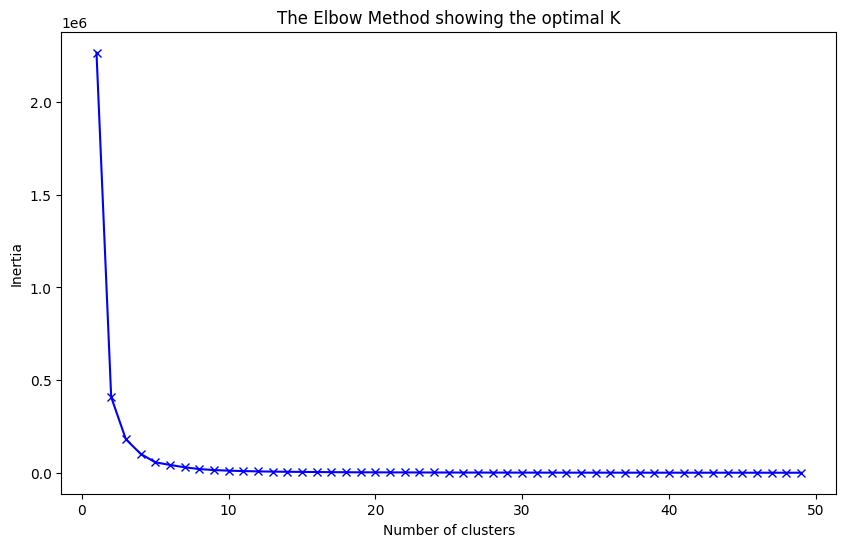

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.cluster import KMeans


# x = df[['KnowledgeTag']]
# scaler = StandardScaler()
# scaled = scaler.fit_transform(x)

# inertia = []

# Km = range(1,50)
# for k in Km :
#     kmeans = KMeans(n_clusters = k, random_state=42)
#     kmeans.fit(scaled)
#     inertia.append(kmeans.inertia_)

# plt.figure(figsize=(10, 6))
# plt.plot(Km, inertia, 'bx-')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('The Elbow Method showing the optimal K')
# plt.show()

In [ ]:
# x = df[['KnowledgeTag']]
# # one hot encoding을 통해 multi hot encoding 진행
# encoder = OneHotEncoder()
# x_encode = encoder.fit_transform(x)

# # 적절한 차원을 찾기 위해 k-means로 대략적으로 확인


# pca = PCA(n_components=5)
# df['KnowledgeTag_pca'] = pca.fit_transform(x)

In [ ]:
# df['elapsed'] = df['elapsed'].fillna(0)

# X = df[['KnowledgeTag', 'elapsed', 'cumulative','paper_number','paper_type', 'paper_subtype', 'paper_number_percent',
#        'paper_type_percent', 'KnowledgeTag_percent']]

# pca = PCA(n_components=1)
# df['elapsed_pca'] = pca.fit_transform(X)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2526700 entries, 0 to 2526699
Data columns (total 48 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   userID                        int64  
 1   assessmentItemID              object 
 2   testId                        object 
 3   answerCode                    int64  
 4   Timestamp                     object 
 5   KnowledgeTag                  int64  
 6   dataset                       int64  
 7   elapsed                       float64
 8   cumulative                    float64
 9   paper_number                  int64  
 10  mean_elaseped_tag             float64
 11  meanelapsed_tag_cor           float64
 12  meanelapsed_tag_wrong         float64
 13  mean_elapsed_paper_num        float64
 14  mean_elapsed_paper_num_cor    float64
 15  mean_elapsed_paper_num_wrong  float64
 16  test_type                     object 
 17  paper_type                    int64  
 18  paper_subtype              

# lgbm

https://www.kaggle.com/code/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761

In [11]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'dataset', 'elapsed', 'cumulative', 'paper_number',
       'mean_elaseped_tag', 'meanelapsed_tag_cor', 'meanelapsed_tag_wrong',
       'mean_elapsed_paper_num', 'mean_elapsed_paper_num_cor',
       'mean_elapsed_paper_num_wrong', 'test_type', 'paper_type',
       'paper_subtype', 'paper_number_percent', 'paper_type_percent',
       'KnowledgeTag_percent', 'paper_number_count', 'tag_count', 'paper_pos',
       'testid_substr', 'user_answer_mean', 'user_ass_cumcount',
       'reverse_answer_cumsum', 'testid_cumsum', 'tag_cumsum',
       'relative_answer_score', 'elapsed_cumsum', 'normalized_elapsed',
       'elapsed_type_mean', 'rolling_mean_time', 'problem_correct_per_user',
       'problem_solved_per_user', 'cum_answerRate_per_user',
       'acc_tag_count_per_user', 'correct_answer_per_as',
       'correct_answer_per_te', 'acc_count_per_as', 'acc_count_per_te',
       'acc_answerRate_per_as

In [109]:
FEATS1 = [
       'KnowledgeTag', 'elapsed', 'cumulative', 'paper_number',
       'mean_elaseped_tag', 'meanelapsed_tag_cor', 'meanelapsed_tag_wrong',
       'mean_elapsed_paper_num', 'mean_elapsed_paper_num_cor',
       'mean_elapsed_paper_num_wrong', 'paper_type',
       'paper_subtype', 'paper_number_percent', 'paper_type_percent',
       'KnowledgeTag_percent', 'paper_number_count', 'tag_count', 'paper_pos']

In [143]:
FEATS2 = ['KnowledgeTag', 'dataset', 'elapsed', 'cumulative', 'paper_number',
       'mean_elaseped_tag', 'meanelapsed_tag_cor', 'meanelapsed_tag_wrong',
       'mean_elapsed_paper_num', 'mean_elapsed_paper_num_cor',
       'mean_elapsed_paper_num_wrong', 'paper_type',
       'paper_subtype', 'paper_number_percent', 'paper_type_percent',
       'KnowledgeTag_percent', 'paper_number_count', 'tag_count', 'paper_pos',
    'user_answer_mean',
       'reverse_answer_cumsum', 'testid_cumsum', 'tag_cumsum',
       'relative_answer_score', 'elapsed_cumsum', 'normalized_elapsed',
       'elapsed_type_mean', 'rolling_mean_time']

In [26]:
FEATS3 = ['KnowledgeTag', 'dataset', 'elapsed', 'cumulative', 'paper_number',
       'mean_elaseped_tag', 'meanelapsed_tag_cor', 'meanelapsed_tag_wrong',
       'mean_elapsed_paper_num', 'mean_elapsed_paper_num_cor',
       'mean_elapsed_paper_num_wrong', 'paper_type',
       'paper_subtype', 'paper_number_percent', 'paper_type_percent',
       'KnowledgeTag_percent', 'paper_number_count', 'tag_count', 'paper_pos',
        'user_answer_mean', 'user_ass_cumcount',
       'reverse_answer_cumsum', 'testid_cumsum', 'tag_cumsum',
       'relative_answer_score', 'elapsed_cumsum', 'normalized_elapsed',
       'elapsed_type_mean', 'rolling_mean_time', 'problem_correct_per_user',
       'problem_solved_per_user',
       'acc_tag_count_per_user', 'correct_answer_per_as',
       'correct_answer_per_te', 'acc_count_per_as', 'acc_count_per_te',
       'acc_answerRate_per_as', 'acc_answerRate_per_te', 'acc_elapsed_per_as',
       'acc_elapsed_per_te']

In [13]:
import os
import random


seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

In [14]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df[df['answerCode'] != -1], test_size = 0.2, random_state = seed, shuffle = True)

y_train = train["answerCode"]
train = train.drop(["answerCode"], axis=1)

y_valid = valid["answerCode"]
valid = valid.drop(["answerCode"], axis=1)

print(train.shape, y_train.shape, valid.shape, y_valid.shape)

(2020764, 47) (2020764,) (505192, 47) (505192,)


In [16]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier

In [27]:
model = LGBMClassifier(n_estimators=1000,
    #                    objective = 'binary',
    # hum_boost_round = 500,
    # early_stopping_rounds = 100,
    # boost_from_average=False
)


model.fit(X=train[FEATS3],
          y=y_train,
          eval_set=[(valid[FEATS3], y_valid)],
          eval_metric="auc",
          # early_stopping_rounds=100,
         )

[LightGBM] [Info] Number of positive: 1323032, number of negative: 697732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5235
[LightGBM] [Info] Number of data points in the train set: 2020764, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654719 -> initscore=0.639846
[LightGBM] [Info] Start training from score 0.639846


LGBMClassifier(n_estimators=1000)

In [28]:
#  LGBoost 모델 추론
preds = model.predict_proba(valid[FEATS3])[:, 1]
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f"VALID AUC : {auc} ACC : {acc}\n")

VALID AUC : 0.8685168640910056 ACC : 0.8148169408858414



In [24]:
import lightgbm as lgb

<Figure size 1000x600 with 0 Axes>

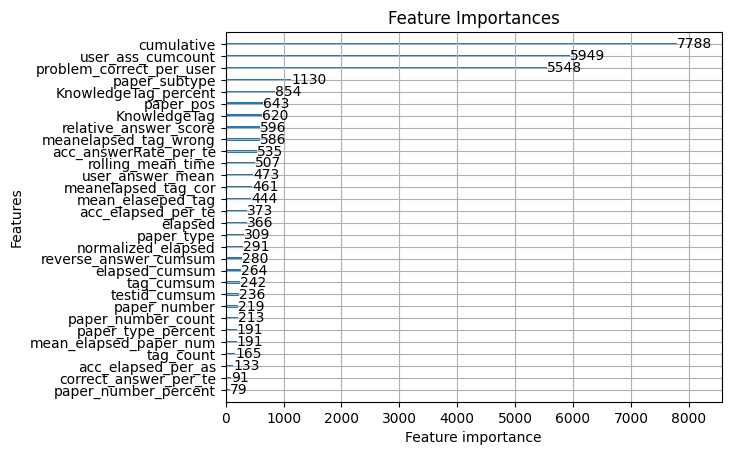

In [29]:
feature_importances = model.feature_importances_

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=30)  # 상위 30개 feature 시각화
plt.title("Feature Importances")
plt.show()


In [ ]:
%pip install shap

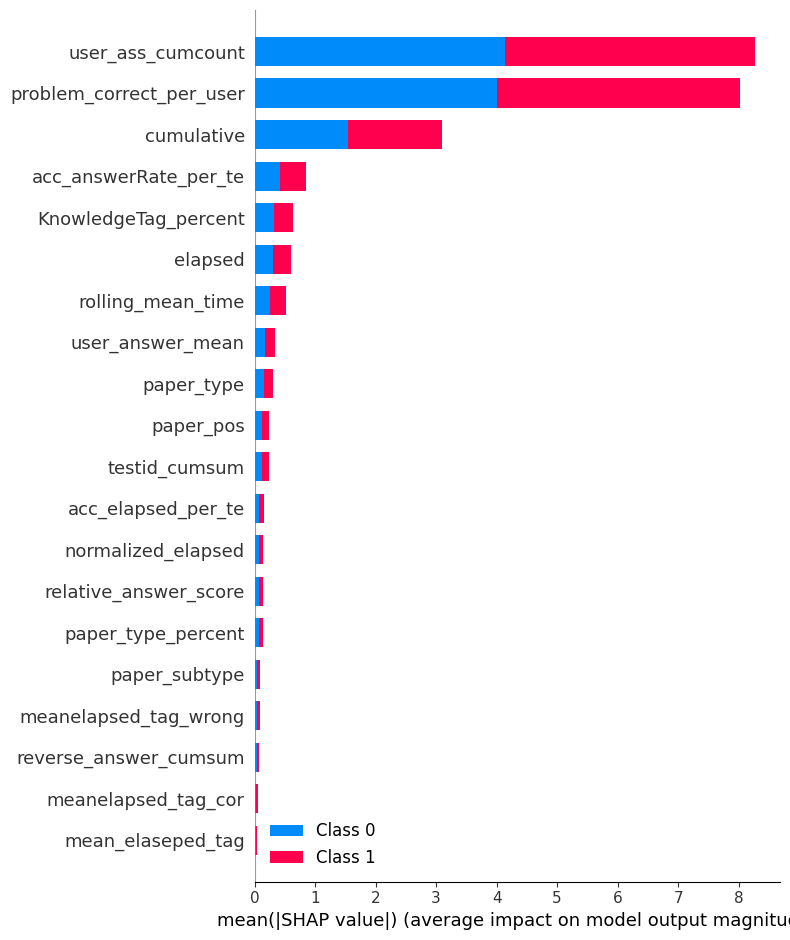

In [32]:
import shap

# SHAP 값을 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(valid[FEATS3])

# SHAP 요약 플롯 시각화
shap.summary_plot(shap_values, valid[FEATS3], plot_type="bar")

In [112]:
test_df = df[df.dataset == 2]
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df["userID"] != test_df["userID"].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(["answerCode"], axis=1)

# MAKE PREDICTION
total_probs = model.predict_proba(test_df[FEATS3])[:,-1]

In [114]:
# SAVE OUTPUT
write_path = os.path.join(/data/ephemeral/code/lightgbm, "submission_Lgbm__.csv")
with open(write_path, "w", encoding="utf8") as w:
    w.write("id,prediction\n")
    for id, p in enumerate(total_probs):
        w.write("{},{}\n".format(id, p))

In [ ]:
# SAVE OUTPUT
output_dir = '/data/ephemeral/code/lightgbm/result/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(preds):
        w.write('{},{}\n'.format(id,p))

In [96]:


# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer',
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum',
#          'elapsed','cumulative','paper_number_percent','paper_type_percent','KnowledgeTag_percent'
#          ]

FEATS = [
       'KnowledgeTag', 'elapsed', 'cumulative', 'paper_number',
       'mean_elaseped_tag', 'meanelapsed_tag_cor', 'meanelapsed_tag_wrong',
       'mean_elapsed_paper_num', 'mean_elapsed_paper_num_cor',
       'mean_elapsed_paper_num_wrong', 'paper_type',
       'paper_subtype', 'paper_number_percent', 'paper_type_percent',
       'KnowledgeTag_percent', 'paper_number_count', 'tag_count', 'paper_pos']


# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)



In [101]:
print(train.shape, y_train.shape, valid.shape, y_valid.shape)

(1768529, 24) (1768529,) (1768529,) (2235,)


In [106]:
FEATS

['KnowledgeTag',
 'elapsed',
 'cumulative',
 'paper_number',
 'mean_elaseped_tag',
 'meanelapsed_tag_cor',
 'meanelapsed_tag_wrong',
 'mean_elapsed_paper_num',
 'mean_elapsed_paper_num_cor',
 'mean_elapsed_paper_num_wrong',
 'paper_type',
 'paper_subtype',
 'paper_number_percent',
 'paper_type_percent',
 'KnowledgeTag_percent',
 'paper_number_count',
 'tag_count',
 'paper_pos']

In [29]:
%pip install lightgbm

In [98]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

일반적인 lightgbm

In [99]:
from lightgbm import LGBMClassifier

lgb_train= LGBMClassifier().fit(train[FEATS], y_train)
lgt_test = LGBMClassifier().fit(test[FEATS], y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2155
[LightGBM] [Info] Number of data points in the train set: 1768529, number of used features: 18
[LightGBM] [Info] Start training from score -8.181101
[LightGBM] [Info] Start training from score -1.063113
[LightGBM] [Info] Start training from score -0.424127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1739
[LightGBM] [Info] Number of data points in the train set: 2235, number of used features: 17
[LightGBM] [Info] Start training from score -2.194544
[LightGBM] [Info] Start training from score -0.804241
[LightGBM] [Info] Start

In [107]:
model = LGBMClassifier(objective = 'binary',
    nhum_boost_round = 500,
    early_stopping_rounds = 100,
    boost_from_average=False
)

model.fit(
    train[FEATS], y_train,
    eval_set = [(train[FEATS], y_train), (valid[FEATS],y_valid)],
    eval_metric='ruc_auc_score',
)

preds = model.predict_proba(valid[FEATS])[:,1]
acc = accuracy_score(y_valid, np.where(preds >= 0.5 ,1 ,0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')


[LightGBM] [Warning] Unknown parameter: nhum_boost_round
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: nhum_boost_round
[LightGBM] [Info] Number of positive: 1323032, number of negative: 697732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.336855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2155
[LightGBM] [Info] Number of data points in the train set: 2020764, number of used features: 18
[LightGBM] [Warning] Unknown parameter: nhum_boost_round
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: nhum_boost_round
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_

KeyboardInterrupt: 

AttributeError: module 'matplotlib.pyplot' has no attribute 'xlable'

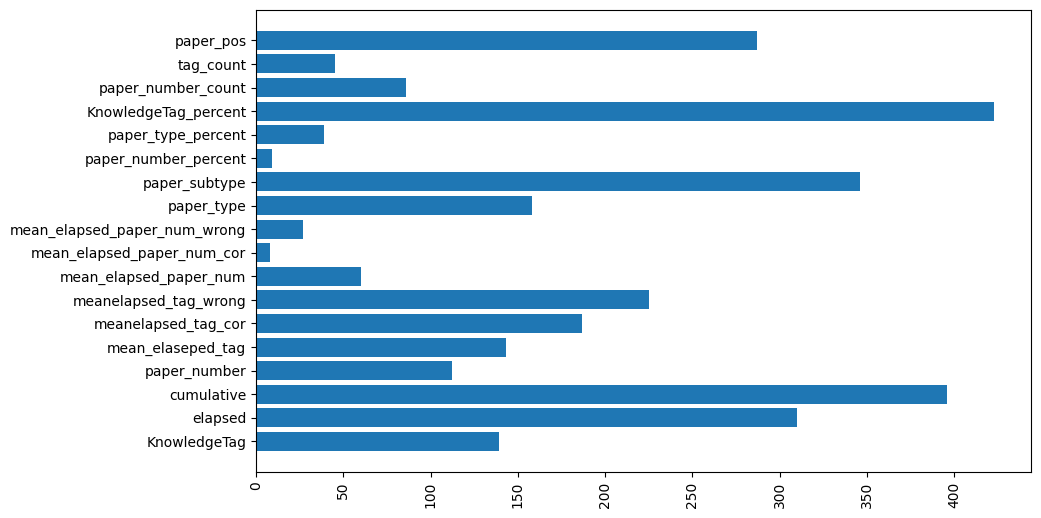

In [80]:
feature = model.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(FEATS, feature)
plt.xticks(rotation=90)
plt.xlable('feature importrance')
plt.ylabel('columns')
plt.show()

In [64]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [69]:

# model = lgb.train(
#     {
#         'objective': 'binary',
#         'learning_rate': 0.05,
#         'num_leaves': 31,
#         'max_depth': 10,
#         'min_data_in_leaf': 20,
#         'feature_fraction': 0.8,
#         'bagging_fraction': 0.9,
#         'bagging_freq': 5,
#         'lambda_l1': 0.1,
#         'lambda_l2': 0.1
#     },
#     lgb_train,
#     valid_sets=[lgb_train, lgb_test],
#     num_boost_round=500,
# )

# preds = model.predict(test[FEATS])
# acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
# auc = roc_auc_score(y_test, preds)

# print(f'VALID AUC : {auc} ACC : {acc}\n')




SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-69-7042175bf69b>, line 37)

optuna를 이용한 lightgbm학습

In [65]:
%pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 0.5),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 0.5)
    }

    gbm = lgb.train(param,
                    lgb_train,
                    valid_sets=[lgb_test],
                    num_boost_round=100,
                    callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )


    preds = gbm.predict(test[FEATS])
    roc_auc = roc_auc_score(y_test, preds)
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


In [ ]:
best_params = study.best_trial.params
print("Best Hyperparameters:", best_params)


In [ ]:
# 필요한 경우, 최적화된 하이퍼파라미터에 추가적인 파라미터를 설정할 수 있습니다.
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'

# 모델 훈련
model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=500,
    early_stopping_rounds=50
)


In [ ]:
# 테스트 데이터셋에 대한 예측
preds = model.predict(test[FEATS])

# 예측된 결과를 기반으로 필요한 평가 지표 계산
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0)) # 이진 분류 임계값 설정
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')


In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(preds):
        w.write('{},{}\n'.format(id,p))

test에 적용

In [ ]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])



In [ ]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244


In [ ]:
diff_test = test_df.loc[:, ['userID','Timestamp']].groupby('userID').diff().shift(-1)
diff_test = diff_test['Timestamp'].apply(lambda x : x.total_seconds())
test_df['elapsed'] = diff_test


In [ ]:
test_df.groupby('userID').apply(lambda x :x.iloc[:-1])

outlier = 1*3600
non_outlier = test_df[test_df['elapsed'] <= outlier]

In [ ]:
mean_elapsed = non_outlier.groupby('KnowledgeTag')['elapsed'].mean()
test_df.loc[test_df['elapsed'] > outlier, 'elapsed'] = test_df[test_df['elapsed'] > outlier].apply(lambda x: mean_elapsed.get(x['KnowledgeTag'], x['elapsed']), axis=1)

In [ ]:
# 누적합
_cumsum = test_df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = test_df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
test_df['cumulative'] = cum_ans['answerCode']

test_df['paper_number'] = test_df['assessmentItemID'].apply(lambda x: x[7:]) # assessmentItemID의 뒤에 3자리를 의미 -> 각 시험지 별로 문제번호
# item 열을 int16으로 변경
test_df["paper_number"] = test_df["paper_number"].astype("int16")

In [ ]:
test_df['test_type'] = test_df['assessmentItemID'].apply(test_type)
test_df['paper_type'] = test_df['assessmentItemID'].apply(paper_type).astype(int)
test_df['paper_subtype'] = test_df['assessmentItemID'].apply(paper_subtype).astype(int)

test_df['paper_number_percent'] = test_df.groupby('paper_number')['answerCode'].transform(avg_percent)
test_df['paper_type_percent'] = test_df.groupby('paper_type')['answerCode'].transform(avg_percent)
test_df['KnowledgeTag_percent'] = test_df.groupby('KnowledgeTag')['answerCode'].transform(avg_percent)

In [ ]:
# FEATURE ENGINEERING
# test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [ ]:
test_df

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,elapsed,cumulative,paper_number,test_type,paper_type,...,paper_number_percent,paper_type_percent,KnowledgeTag_percent,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,NaN,0.691120,8,A,5,...,0.409474,0.662618,0.542662,717.0,1035,0.692754,0.661765,90,0.542662,159
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,NaN,0.691505,8,A,7,...,0.409474,0.515691,0.565693,465.0,670,0.694030,0.740385,77,0.565693,155
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,NaN,0.694002,8,A,7,...,0.409474,0.515691,0.446753,915.0,1316,0.695289,0.417857,117,0.446753,172
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,NaN,0.817460,6,A,9,...,0.560674,0.498492,0.514286,1031.0,1259,0.818904,0.625000,30,0.514286,36
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,NaN,0.754522,7,A,6,...,0.506082,0.733989,0.602767,293.0,386,0.759067,0.678571,133,0.602767,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,2020-09-08 02:05:20,10615,NaN,0.250000,5,A,4,...,0.590899,0.644724,0.654902,7.0,23,0.304348,0.753846,147,0.654902,167
260067,7404,A030111005,A030000111,2020-10-13 09:49:18,7636,NaN,0.400000,5,A,3,...,0.590899,0.697083,0.834661,7.0,14,0.500000,0.866667,156,0.834661,419
260082,7416,A050193004,A050000193,2020-10-04 02:44:41,10402,NaN,0.400000,4,A,5,...,0.664376,0.662618,0.792517,7.0,14,0.500000,0.750000,75,0.792517,233
260097,7417,A050193004,A050000193,2020-09-06 13:09:15,10402,NaN,0.066667,4,A,5,...,0.664376,0.662618,0.792517,2.0,14,0.142857,0.750000,75,0.792517,233


In [ ]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))